# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1n0b7tOzwX9BkvrvNYEga8EQmM5Q8tm9v?usp=sharing


In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
df["age"] = df["age"] + 1
df["age"]

0        40
1        51
2        39
3        54
4        29
         ..
32556    28
32557    41
32558    59
32559    23
32560    53
Name: age, Length: 32561, dtype: int64

In [ ]:
print('The max value of age:', (df['age']).max())
print('The min value of age:', (df['age']).min())
print('The avg value of age:', (df['age']).mean())

The max value of age: 90
The min value of age: 17
The avg value of age: 38.58164675532078


In [208]:
print('The max value of yredu:', (df['yredu']).max())
print('The min value of yredu:', (df['yredu']).min())
print('The avg value of yredu:', (df['yredu']).mean())

The max value of yredu: 1.0
The min value of yredu: 0.0
The avg value of yredu: 0.6053786226875428


In [207]:
print('The max value of capgain:', (df['capgain']).max())
print('The min value of capgain:', (df['capgain']).min())
print('The avg value of capgain:', (df['capgain']).mean())

The max value of capgain: 1.0
The min value of capgain: 0.0
The avg value of capgain: 0.010776596203049367


In [206]:
print('The max value of caploss:', (df['caploss']).max())
print('The min value of caploss:', (df['caploss']).min())
print('The avg value of caploss:', (df['caploss']).mean())

The max value of caploss: 1.0
The min value of caploss: 0.0
The avg value of caploss: 0.02004220150022017


In [205]:
print('The max value of workhr:', (df['workhr']).max())
print('The min value of workhr:', (df['workhr']).min())
print('The avg value of workhr:', (df['workhr']).mean())

The max value of workhr: 1.0
The min value of workhr: 0.0
The avg value of workhr: 0.4024230188989772


In [209]:
df["age"] = (df["age"]-(df['age']).min()) / ((df['age']).max() - (df['age']).min())
df["yredu"] = (df["yredu"]-(df['yredu']).min()) / ((df['yredu']).max() - (df['yredu']).min())
df["capgain"] = (df["capgain"]-(df['capgain']).min()) / ((df['capgain']).max() - (df['capgain']).min())
df["caploss"] = (df["caploss"]-(df['caploss']).min()) / ((df['caploss']).max() - (df['caploss']).min())
df["workhr"] = (df["workhr"]-(df['workhr']).min()) / ((df['workhr']).max() - (df['workhr']).min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
print("percentage of people in our data set are males are:", sum(df["sex"] == " Male")/32561*100, "%")

percentage of people in our data set are males are: 66.92054912318419 %


In [ ]:
print("percentage of people in our data set are females are:", sum(df["sex"] == " Female")/32561*100, "%")

percentage of people in our data set are females are: 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [210]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [211]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [213]:
print("number of records with missing features:", len(df_with_missing))
print('percentage of records being removed:',(df_with_missing.shape[0]/len(df)*100),'%')

number of records with missing features: 1843
percentage of records being removed: 5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing["work"]))

{' Federal-gov', ' State-gov', ' Self-emp-inc', ' Without-pay', ' Local-gov', ' Private', ' Self-emp-not-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [214]:
data

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
32557,0.315068,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
32558,0.561644,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
32559,0.068493,0.533333,0.000000,0.0,0.193878,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

**Answer**
There are 57 columns are in the dataframe data. 

The number comes from original 14 column with string value, plus their expanded categorical values that represented by a one-hot encoding. For example, the columns work expaned to 7 columns.

In [ ]:
print("There are",len(data.columns),"columns in the datafram data")

There are 57 columns in the datafram data


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    
    max_pos = np.argmax(onehot)
    category = cat_values[feature]
    return cat_values[feature][max_pos]

In [ ]:
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
random.shuffle(datanp) # randomly shuffle the data

train_index = int(datanp.shape[0]*0.7)
val_index = train_index + int(datanp.shape[0]*0.15)

train_data = datanp[:train_index]
val_data = datanp[train_index:val_index+1]
test_data = datanp[val_index+1:]

print("number of items in training set:", len(train_data))
print("number of items in validation set:", len(val_data))
print("number of items in test set:", len(test_data))


number of items in training set: 21502
number of items in validation set: 4608
number of items in test set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(57, 40),
            nn.Linear(40, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 40),
            nn.Linear(40, 57),
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**Answer:**
Because the input data is normalized in range of 0 to 1 and the output should be the same in this range. The sigmoid activation is used to convert the value of ouput to between the range 0 and 1.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, batch_size=64):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]
    iters=[]
    for epoch in range(num_epochs):
        
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        iters.append(epoch)
        train_loss.append( float(loss/batch_size) )
        train_acc.append( get_accuracy(model, train_loader) )
        
       
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            valid_loss = criterion(recon, data)


        val_loss.append( float(valid_loss/batch_size))
        val_acc.append(get_accuracy(model, valid_loader))
        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(
            epoch, train_acc[epoch], val_acc[epoch]))
    print("Final Training Accuracy:", train_acc[-1])
    print("Final Validation Accuracy:", val_acc[-1])
    return train_loss, val_loss, train_acc, val_acc, iters
    
    



### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 0 - Training Accuracy: 0.4588255356090906, Validation Accuracy: 0.4558738425925926
Epoch 1 - Training Accuracy: 0.4588255356090906, Validation Accuracy: 0.4558738425925926
Epoch 2 - Training Accuracy: 0.4668247914922643, Validation Accuracy: 0.46292679398148145
Epoch 3 - Training Accuracy: 0.4795445384925433, Validation Accuracy: 0.4763454861111111
Epoch 4 - Training Accuracy: 0.5440036585743961, Validation Accuracy: 0.5385199652777778
Epoch 5 - Training Accuracy: 0.5650714662201965, Validation Accuracy: 0.5616319444444444
Epoch 6 - Training Accuracy: 0.5690788453787244, Validation Accuracy: 0.5657913773148148
Epoch 7 - Training Accuracy: 0.5734505317334821, Validation Accuracy: 0.5697337962962963
Epoch 8 - Training Accuracy: 0.5779462375592969, Validation Accuracy: 0.5730251736111112
Epoch 9 - Training Accuracy: 0.5820853874058227, Validation Accuracy: 0.5767144097222222
Epoch 10 - Training Accuracy: 0.580697919573373, Validation Accuracy: 0.5746889467592593
Epoch 11 - Training 

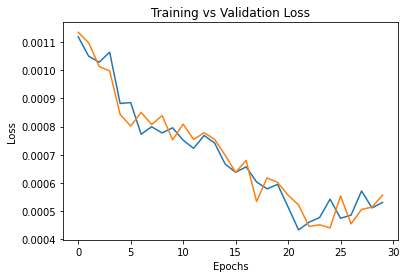

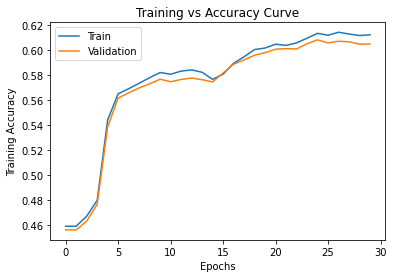

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
model = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, iters=train(model, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4,batch_size=64)

# Plotting
plt.title("Training vs Validation Loss")
plt.plot(iters, train_loss, label="Train")
plt.plot(iters, val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.title("Training vs Accuracy Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [ ]:
#hyperparameters: num_epochs=30, learning_rate=1e-4, batch_size=128
#The loss curve in Part c is a little noisy, 
#so I increase the batch size to 128 and try to make the loss plot smoother
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)
model2 = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, iters=train(model2, train_loader, valid_loader, num_epochs=30, learning_rate=1e-4,batch_size=128)



Epoch 0 - Training Accuracy: 0.33160481195547703, Validation Accuracy: 0.3314163773148148
Epoch 1 - Training Accuracy: 0.4588255356090906, Validation Accuracy: 0.4558738425925926
Epoch 2 - Training Accuracy: 0.4589650575140297, Validation Accuracy: 0.4560546875
Epoch 3 - Training Accuracy: 0.45978668650978205, Validation Accuracy: 0.45601851851851855
Epoch 4 - Training Accuracy: 0.4648947384739404, Validation Accuracy: 0.46198640046296297
Epoch 5 - Training Accuracy: 0.4668170402753232, Validation Accuracy: 0.46274594907407407
Epoch 6 - Training Accuracy: 0.48371469320683347, Validation Accuracy: 0.4794921875
Epoch 7 - Training Accuracy: 0.5345936812079497, Validation Accuracy: 0.5348668981481481
Epoch 8 - Training Accuracy: 0.5501658760425386, Validation Accuracy: 0.5464048032407407
Epoch 9 - Training Accuracy: 0.5576768052584256, Validation Accuracy: 0.5553747106481481
Epoch 10 - Training Accuracy: 0.5645831395529098, Validation Accuracy: 0.5607277199074074
Epoch 11 - Training Accura

In [ ]:
#hyperparameters: num_epochs=30, learning_rate=2e-4, batch_size=128
#from model 2, we can see increase the batch size did make the loss plot becomes smoother,
#but the final accuracy of both training and validation decreases a little.
#so I increase the learning rate to 2e-4 and try to increase the accuracy.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)
model3 = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, iters=train(model3, train_loader, valid_loader, num_epochs=30, learning_rate=2e-4,batch_size=128)


Epoch 0 - Training Accuracy: 0.43773447431246704, Validation Accuracy: 0.4343894675925926
Epoch 1 - Training Accuracy: 0.4588255356090906, Validation Accuracy: 0.4558738425925926
Epoch 2 - Training Accuracy: 0.4669100548786159, Validation Accuracy: 0.46292679398148145
Epoch 3 - Training Accuracy: 0.5273617958019409, Validation Accuracy: 0.5255714699074074
Epoch 4 - Training Accuracy: 0.5552041670542275, Validation Accuracy: 0.5510344328703703
Epoch 5 - Training Accuracy: 0.5673813288686324, Validation Accuracy: 0.5646701388888888
Epoch 6 - Training Accuracy: 0.5724428735311444, Validation Accuracy: 0.5687210648148148
Epoch 7 - Training Accuracy: 0.5787988714228134, Validation Accuracy: 0.5750144675925926
Epoch 8 - Training Accuracy: 0.5798762905776207, Validation Accuracy: 0.5742910879629629
Epoch 9 - Training Accuracy: 0.5781400179828233, Validation Accuracy: 0.5725911458333334
Epoch 10 - Training Accuracy: 0.5794499736458624, Validation Accuracy: 0.5735677083333334
Epoch 11 - Trainin

Epoch 0 - Training Accuracy: 0.45680246798747404, Validation Accuracy: 0.45424623842592593
Epoch 1 - Training Accuracy: 0.5581651319257124, Validation Accuracy: 0.5547598379629629
Epoch 2 - Training Accuracy: 0.5703500449570582, Validation Accuracy: 0.5629340277777778
Epoch 3 - Training Accuracy: 0.5952004464700958, Validation Accuracy: 0.5863353587962963
Epoch 4 - Training Accuracy: 0.60378879484079, Validation Accuracy: 0.6000434027777778
Epoch 5 - Training Accuracy: 0.6043856385452516, Validation Accuracy: 0.5979456018518519
Epoch 6 - Training Accuracy: 0.6094781880755279, Validation Accuracy: 0.6077835648148148
Epoch 7 - Training Accuracy: 0.6053622918798252, Validation Accuracy: 0.6019965277777778
Epoch 8 - Training Accuracy: 0.6086953151644808, Validation Accuracy: 0.6033347800925926
Epoch 9 - Training Accuracy: 0.6162217468142498, Validation Accuracy: 0.6083984375
Epoch 10 - Training Accuracy: 0.621035252534648, Validation Accuracy: 0.6164641203703703
Epoch 11 - Training Accurac

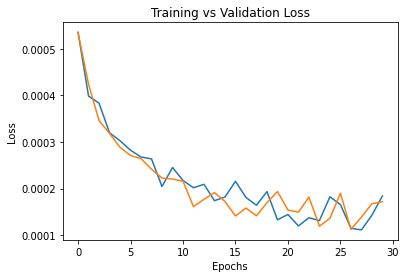

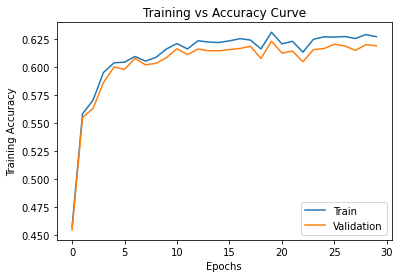

In [215]:
#hyperparameters: num_epochs=30, learning_rate=1e-3, batch_size=128
#from model3, we can see the accuracy still not good as the one in part c
#since large batch size allows for larger learning rates
#the learning rate might not large enough
#so I keep increasing the learning rate to 1e-3
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)
model4 = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, iters=train(model4, train_loader, valid_loader, num_epochs=30, learning_rate=1e-3,batch_size=128)

# Plotting
plt.title("Training vs Validation Loss")
plt.plot(iters, train_loss, label="Train")
plt.plot(iters, val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.title("Training vs Accuracy Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


Epoch 0 - Training Accuracy: 0.4588255356090906, Validation Accuracy: 0.4558738425925926
Epoch 1 - Training Accuracy: 0.46777819117601466, Validation Accuracy: 0.4636501736111111
Epoch 2 - Training Accuracy: 0.5647924224103185, Validation Accuracy: 0.5602575231481481
Epoch 3 - Training Accuracy: 0.5787368616872849, Validation Accuracy: 0.5716869212962963
Epoch 4 - Training Accuracy: 0.5791554274021021, Validation Accuracy: 0.5711443865740741
Epoch 5 - Training Accuracy: 0.5763107307847332, Validation Accuracy: 0.5713252314814815
Epoch 6 - Training Accuracy: 0.5830465383065141, Validation Accuracy: 0.5780526620370371
Epoch 7 - Training Accuracy: 0.6103075682882213, Validation Accuracy: 0.6060112847222222
Epoch 8 - Training Accuracy: 0.6023083124050476, Validation Accuracy: 0.5965711805555556
Epoch 9 - Training Accuracy: 0.6110439338976219, Validation Accuracy: 0.6040943287037037
Epoch 10 - Training Accuracy: 0.6204229063963043, Validation Accuracy: 0.6151982060185185
Epoch 11 - Training

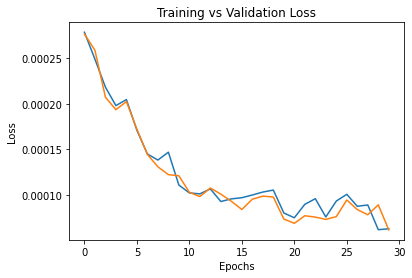

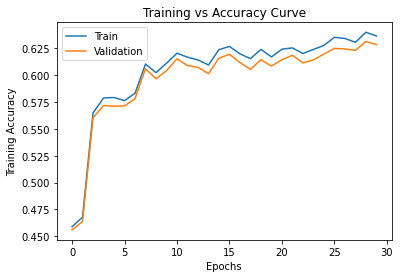

In [220]:
#hyperparameters: num_epochs=30, learning_rate=1e-3, batch_size=256
#from model4, we can see the accuracy becomes higher than it in part c
#but I want to see if the loss curve can be more smooth and if can reach higher accuracy
#so I increase the batch_size to 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=True)
model5 = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, iters=train(model5, train_loader, valid_loader, num_epochs=30, learning_rate=1e-3,batch_size=256)

# Plotting
plt.title("Training vs Validation Loss")
plt.plot(iters, train_loss, label="Train")
plt.plot(iters, val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.title("Training vs Accuracy Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


**Answer:**

**model2:**

Hyperparameters: num_epochs=30, learning_rate=1e-4, batch_size=128

The loss curve in Part c is a little noisy, so I increase the batch size to 128 and try to make the loss plot smoother


**model3:**

Hyperparameters: num_epochs=30, learning_rate=2e-4, batch_size=128

From model 2, we can see increase the batch size did make the loss plot becomes smoother and less noisy, but the final accuracy of both training and validation decreases a little. So I increase the learning rate to 2e-4 and try to increase the accuracy.

**model4:**

Hhyperparameters: num_epochs=30, learning_rate=1e-3, batch_size=128

From model3, we can see the accuracy still not good as the one in part c. Since large batch size allows for larger learning rates, the learning rate might not large enough. So I keep increasing the learning rate to 1e-3

**model5:**

Hyperparameters: num_epochs=30, learning_rate=1e-3, batch_size=256

From model4, we can see the accuracy becomes higher than it in part c, but I want to see if the loss curve can be more smooth and if can reach higher accuracy. so I increase the batch_size to 256.


From the above analysis, I found model 5 perform the best fit so far, with highest accuracy and least noisy loss curve. The hyperparameters are num_epochs=30, learning_rate=1e-3, batch_size=256


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [221]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)
print("Test accuracy", get_accuracy(model5, test_loader))

Test accuracy 0.6366102430555556


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common = []
sum=0
for col in catcols:
  # get the most common value for each column
  most_common.append(df_not_missing[col].value_counts().idxmax())
  sum+= df_not_missing[col].value_counts().max()

accuracy = sum/(df_not_missing.shape[0] *len(catcols))
print("The test accuracy for baseline model is:", accuracy)

The test accuracy for baseline model is: 0.459204158256831


In [ ]:
most_common

[' Private',
 ' Married-civ-spouse',
 ' Prof-specialty',
 ' HS-grad',
 ' Husband',
 ' Male']

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**Answer:**
My test accuracy is 0.6366102430555556 and baseline test accuracy is 0.459204158256831. 
So My test accuracy from part(a) is higher than the baseline test accuracy in part (b)

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

**Answer:**
Yes, I think it is reasonable for a human to be able to guess this person's education level based on their other features. For example, given the below info, a human might guess this person's education level based on occupation. A sales might require Bachelors education.

In [ ]:
get_features(test_data[0])

{'edu': 'Bachelors',
 'marriage': 'Married-civ-spouse',
 'occupation': 'Sales',
 'relationship': 'Husband',
 'sex': 'Male',
 'work': 'Private'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


**Answer:**

My model's prediction of this person's education level is Bachelors.

In [222]:
data_input = torch.from_numpy(test_data[0])
data_input = torch.reshape(data_input, (1, 57))
prediction = model5(zero_out_feature(data_input, 'edu')).detach().numpy()
print(get_feature(prediction[0],'edu'))

Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

**Answer:**

The baseline model prediction of this person is HS-grad.

In [ ]:
feature="edu"
prediction=df_not_missing[feature].value_counts().idxmax()
print("The baseline model's prediction of this person's education level:",prediction)

The baseline model's prediction of this person's education level:  HS-grad
